## makemore: becoming a backprop ninja

In [1]:
# there no change change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
#!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# ok biolerplate done, now we get to the action:

In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3403, grad_fn=<NegBackward0>)

**logprobs**

In [12]:
logprobs.shape

torch.Size([32, 27])

In [13]:
logprobs[range(n), Yb].shape

torch.Size([32])

`loss = -logprobs[range(n), Yb].mean()`

What is loss computing?

`logprobs` has shape (32 x 27)\
`logprobs[range(n), Yb]` : uses range(n) to go through each row, then plucks 1 column out of 27 from each row that corresponds to the index given by `Yb`\
These 32 values will be the ones used in the numercial calculation of the mean as `[x1, x2, ...., x32].mean()`. We want to calculate the gradient of the loss function w.r.t each one of these. What will the formula for the gradient be? 

Smaller example to get the numerical form:
```
loss = (x1 + x2 + x3) / 3
y = f(x) = [x1, x2, x3].mean()
f(x) = (x1 + x2 + x3) / 3
df/dx1 = 1/3
df/dx2 = 1/3
df/dx3 = 1/3
dy = [1/3, 1/3, 1/3]dx
```

What about the rest of the values that were not "plucked" and so not used in the computation of loss?\
If they were not part of the caculation of loss, then their derivative must be 0. 

In [14]:
dlogprobs = torch.zeros(logprobs.shape)
dlogprobs[range(n), Yb] = -1/n 

In [15]:
dlogprobs.shape

torch.Size([32, 27])

In [16]:
# Andrej's code
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n 

**dprobs**

`logprobs = probs.log()` \
This is a log function that takes probs as input and outputs logprobs. ie: `y = f(x) = log(x)`\
The local drrivative of this operation is `dy/dx = 1/x`\
And remeber from our implementation of micrograd : this multiplies the backpropagated derivative from the loss function (in this case it's `dlogprobs`).

In [17]:
dprobs = (1.0/probs) * dlogprobs

What is `dprobs` doing?\
`dprobs = (1.0/probs) * dlogprobs`\
`(1.0/probs)` is the local derivative. `dlogprobs` is the derivative propagated via chain rule.\
`(1.0/probs)`: if probs is 1 or close to 1 (ie ur model is predicting the correct category), then this division's result will be 1 or a small number and `dlogprobs` gradient will just flow back as is or shrunk. If probs are small however (ur model is making the wrong predictions), then this will be a big number and will inflate the `dlogprobs` gradient (asking the model to make bigger changes since it's too far off). 

**dcounts_sum_inv**

Think about this math expression: `probs = counts * counts_sum_inv`

This is like `c = a x b` and we want to backpropagate through `c` so we have to get the derivative w.r.t `a` and derivative w.r.t `b`.\
If usign scalars, this is easy enough. `dc/da = b` and `dc/db = a`. How to do it for matrices?\
Here, we have to be careful about the shapes: 

In [18]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

`probs = counts * counts_sum_inv`
 is the same line as\
`probs = counts / counts.sum()`

Notice there are 2 operations happening here:
- One is the broadcasting (replication) of the 1 column of `counts_sum_inv` across 27 columns.
- Two is the element-wise division occuring.

So, we'll do our gradient calculation in 2 steps as well:

```
c = a x b with tensors will be
a(3x3) * b(3x1)
a11 a12 a13   b1
a21 a22 a23   b2
a31 a32 a33   b3

When broadcast

a11*b1  a12*b1  a13*b1  
a21*b2  a22*b2  a23*b2
a31*b3  a32*b3  a33*b3

And this becomes c(3x3)
```

In this example, `c` is `probs`, `a` is `counts` and `b` is `counts_sum_inv`

We want `dprobs / dcounts_sum_inv` ie `dc/db` which in this case is `a` or `counts`. Notice, this is the derivative w.r.t the "replicated" `b`.

But now, we need to backpropagate through the replication. We can see for eg `b1` is the same variable being used multiple times. We saw with autograd that if a variable (single node) is used multiple times (feeds into multiple nodes), we need to sum all the gradients that come from all of its uses. 

Since `b` is used in multiple columns, the right thing to do is to sum across them.

In [19]:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

**dcounts**

In [20]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [21]:
dcounts = counts_sum_inv * dprobs

In [22]:
dcounts.shape

torch.Size([32, 27])

If you check `cmp('counts', dcounts, counts)` now you'll get an error.Why? Look at the code:
```
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
```

U can see we backpropagated from `counts` to `probs`. But, `counts_sum_inv` also uses `counts` in `counts_sum_inv = counts_sum**-1` so we still have to resolve this branch before we get the correct result (we still have to calculate the second contribution). 

**dcounts_sum**

```
counts_sum_inv = counts_sum**-1
dcounts_sum_inv / dcounts_sum = - counts_sum**-2
```

In [23]:
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv

**dcounts**

`counts_sum = counts.sum(1, keepdims=True)`

`counts_sum` results from a sum operation over `counts`
First, look at the shapes: 

In [24]:
counts_sum.shape, counts.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

```
c1 c2 c3
c4 c5 c6
c7 c8 c9

Sum across columns to give (cs:count_sum , c:counts)

cs1 (c1+c2+c3) 
cs2 (c4+c5+c6)
cs3 (c7+c8+c9)

dcs1/dc1 = 1 + 0 + 0

Same for else

Now, the drrivative of cs1 will depend on c1,c2,c3 but won't depenend on c4,c5...c9. So, derivative of cs1 w.r.t c1 will be 1 - also for c2 and c3 - but will be 0 for all else.
```

This will be multiplied by the derivative flowing backwards from the chain rule. But we have to be careful because we already calculated `dcounts` from a previous branch so we need to make sure these branches add up (use `+=`)

In [25]:
dcounts += torch.ones_like(counts) * dcounts_sum

**dnorm_logits**

`counts = norm_logits.exp()`

We want:

`dcounts / dnorm_logits`. `counts` here results from an element-wise exponentiation process `exp(norm_logits)` as if we're doing:
```
exp ( x1 x2 x3
      x4 x5 x6
      x7 x8 x9 )
```

We know derivative of exp is exp

In [26]:
dnorm_logits = norm_logits.exp() * dcounts

In [27]:
norm_logits.shape

torch.Size([32, 27])

**dlogit_maxes & dlogits** 

We want: `dnorm_logits / dlogit_maxes`

`norm_logits = logits - logit_maxes # subtract max for numerical stability`

In [28]:
logit_maxes.shape, logits.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

```
c = a - b
dc/da = 1
dc/db = -1

How to do it for matrices?

max ( x1 x2 x3
      x4 x5 x6
      x7 x8 x9 )

suppose b = 
x2
x4
x9

c = 
x1-x2  x2-x2  x3-x2
x4-x4  x5-x4  x6-x4
x7-x9  x8-x9  x9-x9

=

dc/da =
1 1 1
1 1 1
1 1 1

dc/db =

-1 -1 -1
-1 -1 -1
-1 -1 -1
```

If these local gradients are -1, 1, then they will allow the backpropagated gradient `dnorm_logits` to flow backwards as they are (except reversing the sign for dlogit_maxes).\
Also, keep in mind, for `db => dlogit_maxes`, we replicated / broadcast it to do the subtraction, so we need to sum back the gradients across the dimnsion we replicated (columns).

In [29]:
dlogits = dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdims=True)

Remeber, `logits` is also used in another branch `logit_maxes = logits.max(1, keepdim=True).values`. We need to compute it before we get the final correct derivative for it

A note on `dlogit_maxes`:

Remeber where it came from: `norm_logits = logits - logit_maxes # subtract max for numerical stability`

Recall the discussion on numerical stability. We subtract `logit_maxes` from `logits` (subtract max of each row from the cell in that row). This is sort of normalizing to prevent arbitrarily high numbers from logits which could mess up the calculations later when we do exp and log and such resulting in floating point problems. But, since we subtract equally from all values in each row, this subtracted value `logit_maxes` should have no impact on `probs` or the final loss. We can double check that by looking at their gradients. We expect it to be 0 or very small values:

In [30]:
dlogit_maxes

tensor([[ 2.5611e-09],
        [-3.7253e-09],
        [-1.8626e-09],
        [ 1.3970e-09],
        [-4.6566e-10],
        [ 2.3283e-10],
        [-0.0000e+00],
        [ 2.7940e-09],
        [ 3.7253e-09],
        [ 4.6566e-10],
        [-9.3132e-10],
        [ 4.6566e-10],
        [-1.8626e-09],
        [-3.7253e-09],
        [-1.8626e-09],
        [-6.9849e-10],
        [-4.1910e-09],
        [-9.3132e-10],
        [-3.7253e-09],
        [-2.3283e-09],
        [-3.7253e-09],
        [-7.2177e-09],
        [ 3.7253e-09],
        [ 3.2596e-09],
        [ 1.8626e-09],
        [ 1.6298e-09],
        [-1.3970e-09],
        [-2.7940e-09],
        [ 1.8626e-09],
        [-1.8626e-09],
        [-1.8626e-09],
        [ 1.1642e-09]], grad_fn=<NegBackward0>)

And we see this is indeed the case. In implementation we might actually choose not to backpropagate through this branch and set its derivative to 0.

**dlogits**

From : `logit_maxes = logits.max(1, keepdim=True).values`

In [31]:
indices, values = torch.tensor([[1,2],[4,3],[5,6]]).max(dim=1,keepdim=True)

In [32]:
indices, values

(tensor([[2],
         [4],
         [6]]),
 tensor([[1],
         [0],
         [1]]))

```
c = max(a, b) 


max ( x1 x2
      x3 x4
      x5 x6 )

suppose b = 
x2
x4
x5

what we get is

x2 = max(x1, x2)
x4 = max(x3, x4)
x5 = max(x5, x6)

And intuitively, if we change x1, it should have no impact on x2 so derivative = 0 or dx2/dx1 = 0 , while dx2/dx2 = 1

```

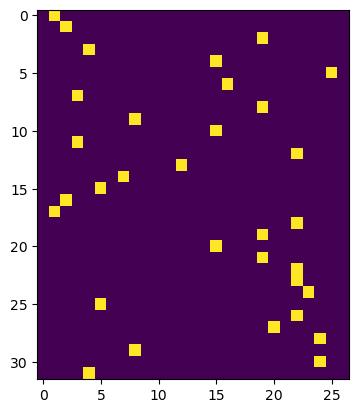

In [33]:
max_indices = logits.max(dim=1).indices # to represent as list
dlogits2 = torch.zeros_like(logits)
dlogits2[torch.arange(logits.shape[0]), max_indices] = 1
plt.imshow(dlogits2);
dlogits += (dlogits2 * dlogit_maxes)

In [34]:
# Andrej's code

# we need to run these 2 lines to reset the code
dlogits = dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdims=True)

# then the new branch
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

**dh, dW2, db2**

`logits = h @ W2 + b2`

`$$\begin{bmatrix} 1 & 2 & 1 \\ 3 & 0 & 1 \\ 0 & 2 & 4 \end{bmatrix}$$`

$$\begin{bmatrix} 1 & 2 & 1 \\ 3 & 0 & 1 \\ 0 & 2 & 4 \end{bmatrix}$$

$$\begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix}$$

### Finish converting the handwritten notes to latex notes here later

Long story short: we find that backward pass of matrix multiplication is a matrix multiplication.
```
if: d = a @ b + c, and loss is L such that we have dL / dd
dL/da = dL/dd @ b.T
dL/db = a.T @ dL/dd
dL/dc = dL/dd.sum(0)
```
In both cases, it's like the scalar case where the final derivative is the backpropagaed derivative x the other term in the multiplication (in the case of `a` and `b`), and for `c` it's a sum.

**The Hacky Way**

Now, do we need to remember these formulas? Do we need to derive them every time?\
No. We can get the right results by remebering a couple of things: 
1. The result will be some sort of matrix multiplication of the backpropagated loss by one of the terms transposed (in the case of multiplication) or it's the backpropagated loss summed across some dimension in case of bias term.
2. The shapes of the matrices must work out.

What does that mean? 

We have `logits = h @ W2 + b2`. We want: `dh, dW2 and db2`. Their shapes of these derivatives must correspond to the matrices they're supposed to be the derivative of. ie shape of `dh` same as `h`, `dW2` same as `W2` and so on.

In [35]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

If we start with `dh`, it has to be 32 x 64. And we know we get it via matrix multiplying `dlogits` (32 x 27) by `W2` (64 x 27). The only way to get this is if we do `dlogits @ W2.T` 

In [36]:
dh = dlogits @ W2.T
dh.shape

torch.Size([32, 64])

And indeed we get that.
Let's do the same for the others:

In [37]:
dW2 = h.T @ dlogits
dW2.shape

torch.Size([64, 27])

In [38]:
db2 = dlogits.sum(0)
db2.shape

torch.Size([27])

**dhpreact**

`h = torch.tanh(hpreact)`

Remeber the formula from micrograd:

if $$t = tanh(x) = \frac{exp(2x - 1)}{exp(2x + 1)} $$

Then:

$$ \frac{dt}{dx} = \frac{dtanh(x)}{dx} = 1 - t^2 $$

Keep in mind the derivative is in terms of the output of tanh -> t not the input x.

In [39]:
hpreact.shape

torch.Size([32, 64])

In [40]:
dhpreact = (1 - h**2) * dh
dhpreact.shape

torch.Size([32, 64])

**dbngain, dbnraw, dbnbias**

`hpreact = bngain * bnraw + bnbias` 

We want:

```
dhpreact / dbngain
dhpreact / dbnraw
dhpreact / dbnbias
```

This is a simple case because we have element-wise multiplication not matrix multiplication so it will be same as doing derivative for:

```
d = a * b + c
dd/da = b
dd/db = a
dd/dc = 1
```

In [41]:
dhpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

and we just need to be careful about the shapes because there is broadcasting going on so whenever a row is replicated vertically, we need to sum the final result across rows (dim=0) and so on:

In [42]:
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnraw =  bngain * dhpreact
dbnbias = dhpreact.sum(dim=0, keepdim=True)

**Backpropagating through the BatchNorm Layer**

```
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
```

**dbnvar_inv, dbndiff**

`bnraw = bndiff * bnvar_inv`

In [43]:
# as usual, check the shapes first
bnraw.shape, bndiff.shape , bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [44]:
# this is element-wise so it's easy
dbndiff = dbnraw * bnvar_inv
dbndiff.shape

torch.Size([32, 64])

In [45]:
dbnvar_inv = (dbnraw * bndiff).sum(dim=0, keepdim=True) 
dbnvar_inv.shape

torch.Size([1, 64])

Next `bnvar_inv = (bnvar + 1e-5)**-0.5`

In [46]:
# check the shapes
dbnvar_inv.shape, bnvar.shape, dbnraw.shape

(torch.Size([1, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

In [47]:
dbnvar = ((-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv).sum(dim=0, keepdim=True)

Next: `bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)`

In [48]:
bnvar.shape, bndiff2.sum(0, keepdim=True).shape

(torch.Size([1, 64]), torch.Size([1, 64]))

Toy example:

```
(a11 a12
 a21 a22).sum(0, ..) 

* (1 / n-1)

-->

b1 = 1/(n-1) * (a11 + a21) # sum over rows then scale by 1/n-1
b2 = 1/(n-1) * (a12 + a22)

db / da =

[ db1/da11  db1/da12
  db2/da21  db2/db22 ]

=>
db1/da11 = 1/(n-1) * (1 + 0)
db1/da12 = 1/(n-1) * (1 + 0)
db2/da21 = 1/(n-1) * (1 + 0)
db2/db22 = 1/(n-1) * (1 + 0)

=

[ 1 1
  1 1 ]
```

In [49]:
dbndiff2 = (torch.ones_like(bndiff2) * (1.0 / (n-1))) * dbnvar
dbndiff2.shape

torch.Size([32, 64])

Next `bndiff2 = bndiff**2`

In [50]:
# check the shapes
bndiff2.shape, bndiff.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [51]:
# add the old branch to reset every time we run this
dbndiff = dbnraw * bnvar_inv
# then the new one
dbndiff += 2*bndiff * dbndiff2
dbndiff.shape

torch.Size([32, 64])

Next `bndiff = hprebn - bnmeani`

In [52]:
# check the shapes
dbndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

```
c = a - b
dc/da = 1 - 0
dc/db = 0 - 1
```

In [53]:
# the subtraction is a simple case
dhprebn  =   dbndiff.clone()
dbnmeani =  -dbndiff.clone().sum(dim=0, keepdim=True)
dbnmeani.shape, dhprebn.shape 

(torch.Size([1, 64]), torch.Size([32, 64]))

Next: `bnmeani = 1/n*hprebn.sum(0, keepdim=True)`

This is similar to a previous case 

```
(a11 a12
a21 a22).sum(0, ...)

x

1/n

-->

b1 = 1/n * (a11 + a21)
b2 = 1/n * (a12 + a22)

db / da -->

[ db1/da11 db1/da21
  db2/da12 db2/da22 ]

[1 1
 1 1] * 1/n
```

In [54]:
bnmeani.shape, hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [55]:
dhprebn  =   dbndiff.clone() # run previous branch

dhprebn += ((1/n) * dbnmeani) * torch.ones_like(hprebn) # torch.ones_like(hprebn): to replicate to compensate for the sum
dhprebn.shape

torch.Size([32, 64])

The final layers:

```
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
```

Next: `hprebn = embcat @ W1 + b1`

This is similar to the matrix layer we did before. Let's see if we can do it the "Hacky" way:

In [56]:
# check the shapes
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [57]:
# we know dembcat needs to be 32 x 30 and it results from matrix multipying dhprebn (32 x 64) and W1 (30 X 64) someway
dembcat = dhprebn @ W1.T
dembcat.shape

torch.Size([32, 30])

In [58]:
# we know dW1 needs to be 30 x 64 and it results from matrix multipying dhprebn (32 x 64) and embcat (32 x 30) somehow
dW1 = embcat.T @ dhprebn
dW1.shape

torch.Size([30, 64])

In [59]:
# fianlly db1 will be 1s multiplied by hprebn 32 x 64 but collapsed to 64 

In [60]:
db1 = dhprebn.clone().sum(dim=0)
db1.shape

torch.Size([64])

And it works :)))

Next: `embcat = emb.view(emb.shape[0], -1)`

We have the derivative of `embcat` and we want to backpropagate to `emb`

In [61]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

emb is embcat (so same gradient) but with different shape. We just need to reshape

In [62]:
demb = dembcat.view(emb.shape)

Finally: `emb = C[Xb]`

In [63]:
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


We have the derivative of `emb`, we want to backpropagate to `C`

Let's remind ourselve what is going on in `emb = C[Xb]`

We have `C` a 27 x 10 feature vector matrix. `Xb` has examples each made of 3 letters. We want to pluck out the corresponding 3 x 10 feature vectors from `C` that encode the 3 letters/ indices in `Xb`. Each feature vector can obviously be used multiple times for encoding multiple examples.

In `demb`, we now have the gradients to these features from each example. We want to route them to the correct feature in `C`. So, for each example in `Xb`, we want to select the `demb` gradients that correspond to it. Each example has 3 x 10 letters. These letters will fall into 27 possibilities in a `dC` matrix that is 27 x 10. If we see a letter's gradient from multiple examples, we should add them up.  

In [64]:
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]): # go through each example
    for j in range(Xb.shape[1]): # each index in the example
        ix = Xb[i, j] # pluck index of each letter in the example
        dC[ix] += demb[i, j] # demb[i,j] -> gets us the 10 gradients

**My Hacky Vectorized Version**

Karpathy was saying he didn't know a better way to do this than for loops. I tried to do one.

In [65]:
one_hot = torch.nn.functional.one_hot(Xb, num_classes=27).float()
one_hot = one_hot.view(-1, 27)

In [66]:
one_hot.shape

torch.Size([96, 27])

In [67]:
demb_reshaped = demb.view(32*3, -1)
demb_reshaped.shape

torch.Size([96, 10])

In [68]:
dC2 = one_hot.T @ demb_reshaped

And we're done :))))

In [69]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)
cmp('C2', dC2, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

#### Exercise 2: 

backprop through cross_entropy but all in one go. To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out

Cross Entropy explained:

Remeber how we computed the loss function:
```
logits = xenc @ W # predict log-counts

counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)
# probabilities for next character. These last 2 lines here are together called a 'softmax'

p = probs[i, y] # pluck out the row for the current label
logp = torch.log(p)
nll = -logp
nlls[i] = nll
```

We see from this, the loss for a single example is
$$ L = -log(P_y) $$
Where $P_y$ is a vector of probabilities representing the distribution of y across all possible categories of the output.

Inside $P_y$ are individual probabilities $p_i$ where:

$$p_i = \frac{exp(z_i)}{\sum_{j=1}^{C} exp(z_j)}$$

Where $z_k$ is the logit of the correct class and $C$ is the number of possible classes. 

What we want is the derivative of the Loss w.r.t each logit output ie:

$$ \frac{\partial L}{\partial z_i} $$

We can see an toy example of the computations for the steps above in the following table:

|      label   |      output   |   exp  |   softmax/probs |   one-hot/$y_i$ |   index |
|:-------------:|:-------------:|:-----:|:---------:|:--------:|:-------:|
|      a       | -4.89         |   0.01 |     0    |    0      |    0    |
|      b       |  2.60         |  13.43 |     0.87 |    1      |    1    |
|      c       |  0.59         |   1.81 |     0.12 |    0      |    2    |
|      d       | -2.07         |   0.13 |     0.01 |    0      |    3    |
|      e       | -4.57         |   0.01 |     0    |    0      |    4    |
|              | 15.38         |   1.00 |          |           |         |


If our logits are $l_i$, we want $$\frac{dLoss}{dl_i}$$ where $$p_i = \frac{exp(l_k)}{\sum_{j=1}^{C} exp(l_j)}$$


Via chain rule this is:

$$ \frac{dLoss}{dp_i} * \frac{dp_i}{dl_i} $$

$\frac{dp_i}{dl_i}$ is the derivative of the softmax function. Let's do that first: 

$$p_i = \frac{exp(l_k)}{\sum_{j=1}^{C} exp(l_j)}$$

There are 2 cases here:
1. $k = i$ : The case for the right label
2. $k \neq i $ : The case for all other labels

Remeber the Quotient rule:

The derivative quotient rule states that for two differentiable functions, $u(x)$ and $v(x)$, the derivative of their quotient $\frac{du(x)}{dv(x)}$ is given by:


$$\frac{d}{dx}\left(\frac{u(x)}{v(x)}\right) = \frac{v(x) \cdot u'(x) - u(x) \cdot v'(x)}{v(x)^2}$$

Or what I like to remeber as: 
$$ \frac{d{up}*down - d{down}*up}{(down)^2}$$

$$ddown = \frac{\sum_{j=1}^{C} exp(l_j)}{dl_i} = exp(l_i) $$

where if the sum is $exp(l_i) + exp(l_k) + exp(l_a) ...$ etc, then one of the summed elements will always be the correct class $l_i$ whose derivative is itself $exp(l_i)$ and all else is 0.

In the case of $k = i$ this becomes:

$$= \frac{{\frac{dexp(l_i)}{dl_i}}*\sum - d{\sum}*exp(l_i)}{(\sum)^2}$$

$$= \frac{exp(l_i) * \sum - exp(l_i) * exp(l_i)}{(\sum)^2}$$

$$= \frac{exp(l_i)}{\sum} - (\frac{exp(l_i)}{\sum})^2 $$
$$= p_i - p_i^2 $$

In the case where $k \neq 1$ this becomes

$$= \frac{{\frac{dexp(l_k)}{dl_i}}*\sum - d{\sum}*exp(l_k)}{(\sum)^2}$$
$d\sum$ we know = $exp(l_i)$
$$= \frac{ 0 * \sum - exp(l_i) * exp(l_k)}{(\sum)^2} $$
$$= \frac{- exp(l_i) * exp(l_k)}{(\sum)^2}$$
$$ = - \frac{exp(l_i)}{\sum} * \frac{exp(l_k)}{\sum} $$
$$ = - p_i * p_k $$

Now we have the derivative of softmax, let's do the Loss function: $$ \frac{dLoss}{dl_i}$$ where $$ Loss = -log(P_y)$$

Recall $$\frac{d}{dx} log(x) = \frac{1}{x}$$

$$ \frac{d(-log(P_y))}{dl_i} = - \frac{1}{P_y} * \frac{dP_y}{dl_i} $$

We know in the case of $y = i$ then $$\frac{dP_y}{dl_i} = P_y - (P_y)^2 = P_y(1 - P_y)$$

So we replace this term and we get:

$$ \frac{d(-log(P_y))}{dl_i} = - \frac{1}{P_y} * P_y(1 - P_y) = P_y - 1$$

And if $ y \neq i$ (such that y = some k; $y = k$) then $$\frac{dP_y}{dl_i} = -P_y * P_k $$

$$ \frac{d(-log(P_k))}{dl_i} = - \frac{1}{P_k} * -P_y * P_k = P_y$$

Keep in mind:
1. $P_y$ is a vector of probabilities produced by Softmax
2. This is done for a single example. In our code, we work with batches of examples. The loss for a batch is the average loss over all the examples

In [70]:
# in code
logits.shape

torch.Size([32, 27])

In [71]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3402700424194336 diff: 4.76837158203125e-07


In [72]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = None # TODO. my solution is 3 lines
# -----------------

dlogits = F.softmax(logits, dim=1) # each row is one example. Its sum will be sum across all 27 columns
# then, at the correct positions (columns) (Yb), the derivative is P - 1
dlogits[range(logits.shape[0]), Yb] -= 1 # we could replace logits.shape[0] with n which is the batch size
# then, we remember loss computes averge loss: loss = -logprobs[range(n), Yb].mean(). We just computed the 
# gradient for the absolute loss for each example. We need now to scale it down to be for the average loss 
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


In [73]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(9.5367e-07, grad_fn=<MaxBackward1>)


In [77]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
dhprebn = (bngain * bnvar_inv) * ( dhpreact - dhpreact.sum(0)/n -  (bnraw * (dhpreact*bnraw).sum(0))/(n-1) )
#dhprebn = bngain*bnvar_inv/n * ((n*dhpreact - dhpreact.sum(0)) - n/(n-1) * bnraw * (dhpreact*bnraw).sum(0))
# -----------------
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


In [79]:
hprebn.shape, dhprebn.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))